In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import cProfile
from datetime import datetime
import importlib
import numpy as np
import os
import yaml
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, make_logger

config_path = "config/mcts_d_score_replication.yaml"
with open(os.path.join(repo_root, config_path)) as f:
    conf = yaml.safe_load(f)

output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
logger = make_logger(output_dir)

transition_conf = conf.get("transition_conf", {})
if "model_dir" in transition_conf:
    transition_conf["model_dir"] = os.path.join(repo_root, transition_conf["model_dir"])
lang_path = conf.get("lang_path")
if lang_path is None:
    lang_name = os.path.basename(os.path.normpath(transition_conf["model_dir"])) + ".lang"
    lang_path = add_sep(transition_conf["model_dir"]) + lang_name
lang = Language.load(lang_path, device=conf.get("device"))
transition_class = class_from_package("transition", conf["transition_class"])
transition = transition_class(lang=lang, logger=logger, **transition_conf)

reward_class = class_from_package("reward", conf.get("reward_class"))
reward = reward_class(**conf.get("reward_conf", {}))
policy_class = class_from_package("policy", conf.get("policy_class"))
policy = policy_class(**conf.get("policy_conf", {}))

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/home/fujii/anaconda3/envs/v3-forge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Is CUDA available: True


Starting generation...
generated: 100, time: 17.24, average over 100: 0.1624
generated: 200, time: 35.13, average over 100: 0.1420
generated: 300, time: 51.32, average over 100: 0.1606
Generation completed.


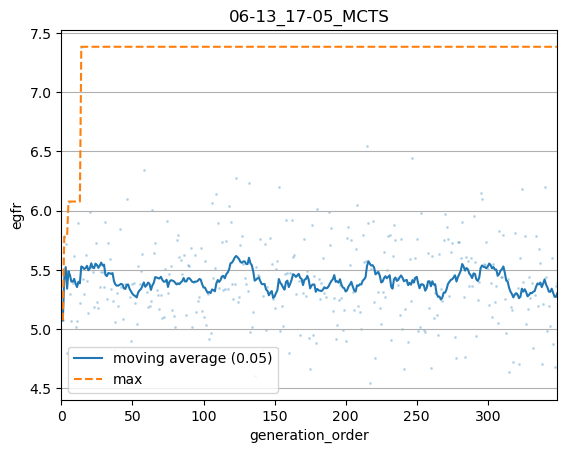

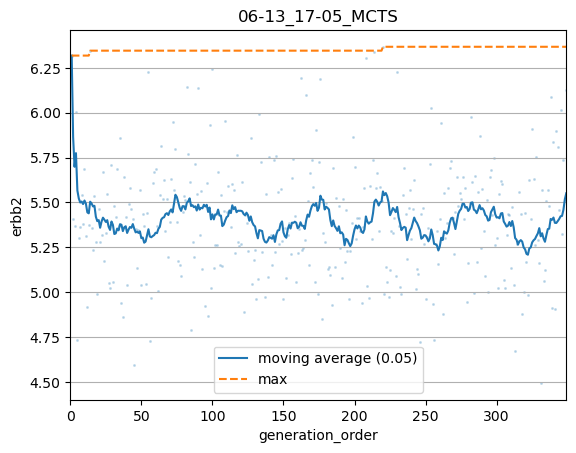

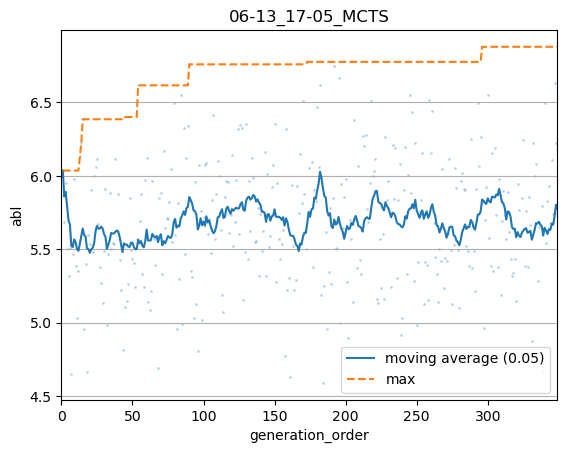

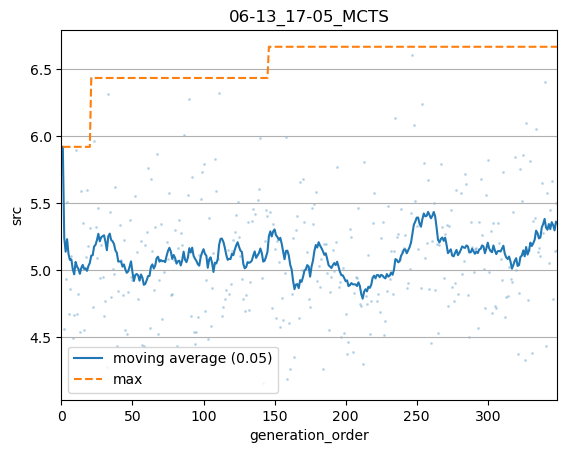

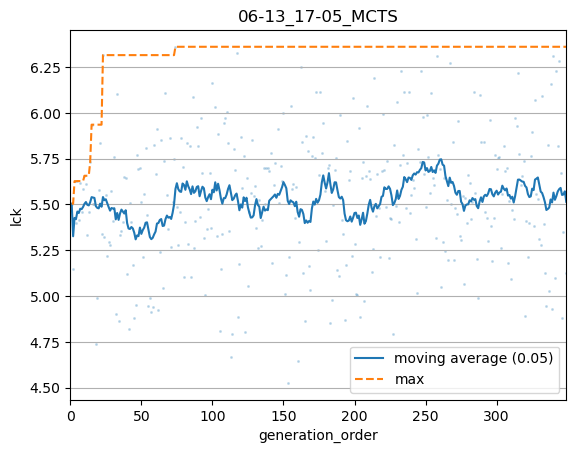

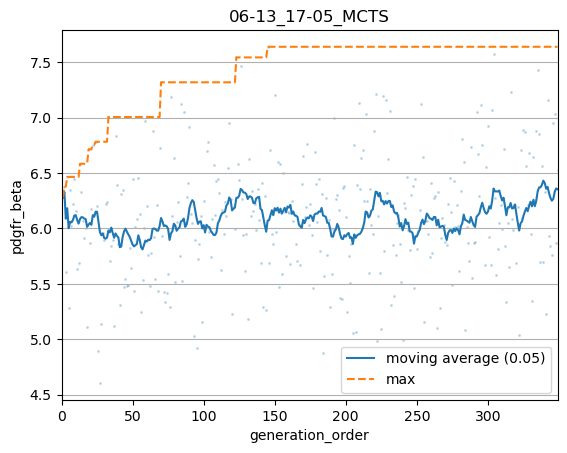

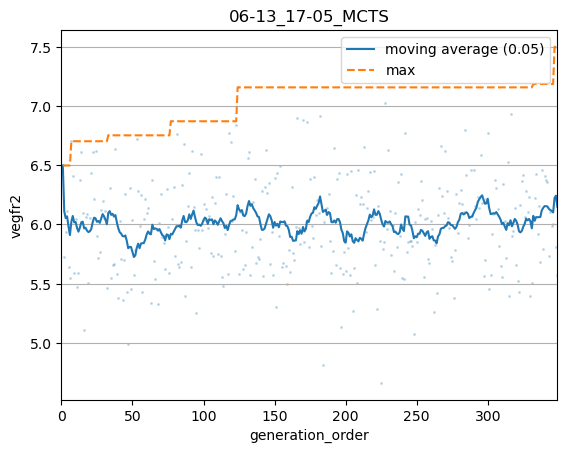

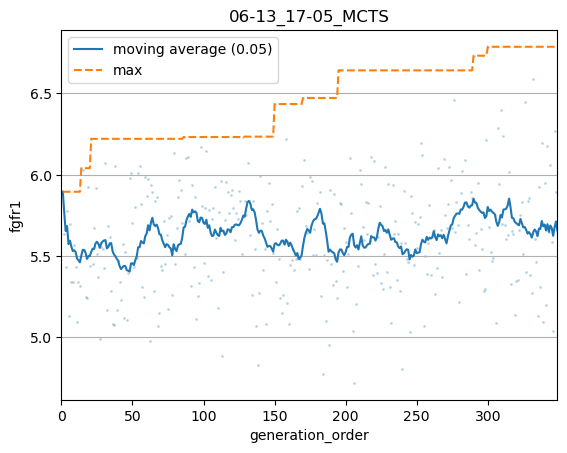

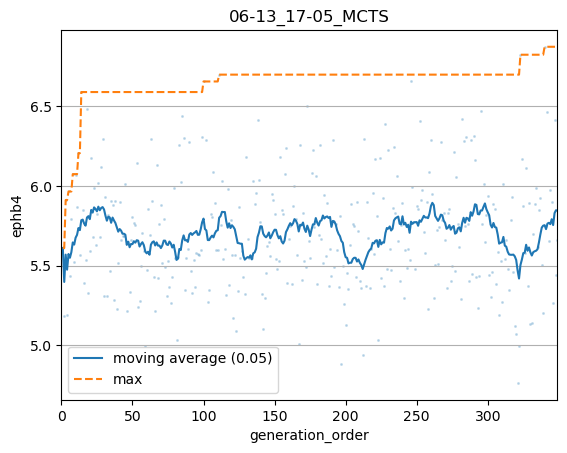

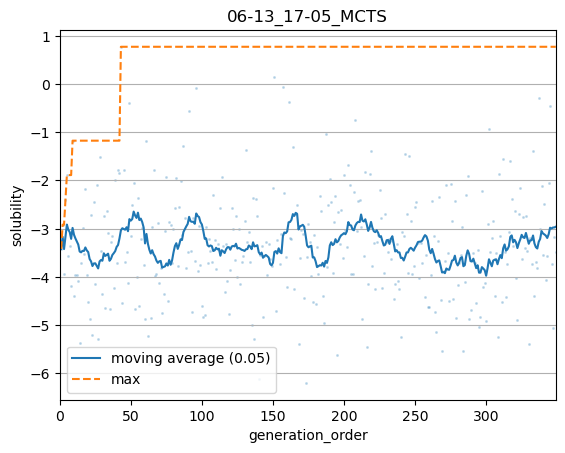

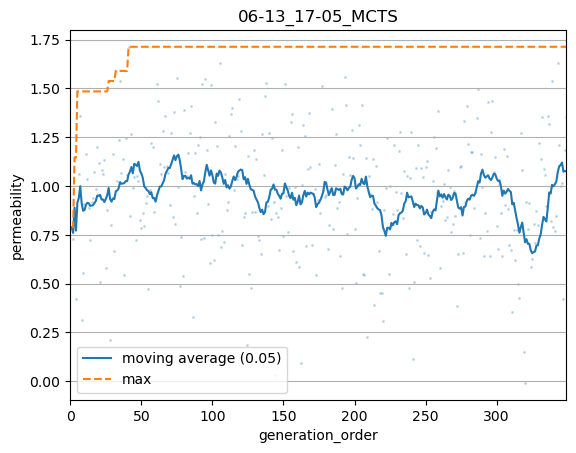

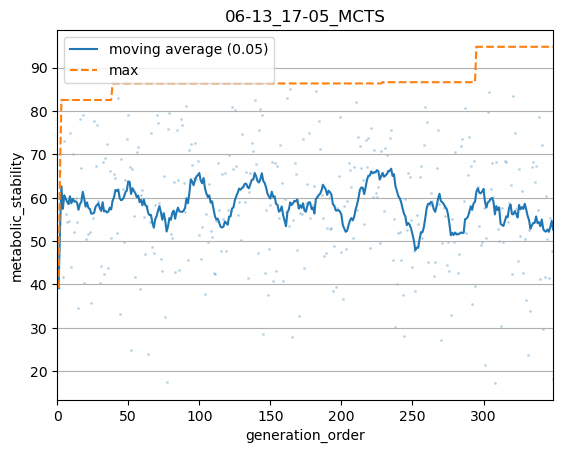

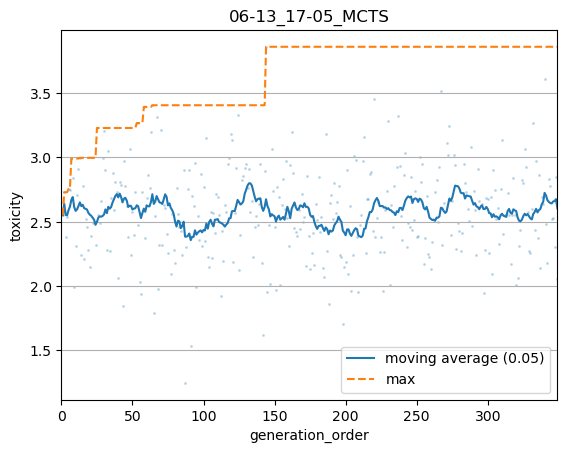

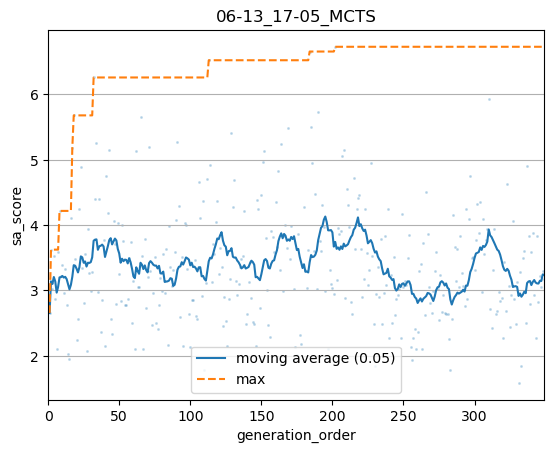

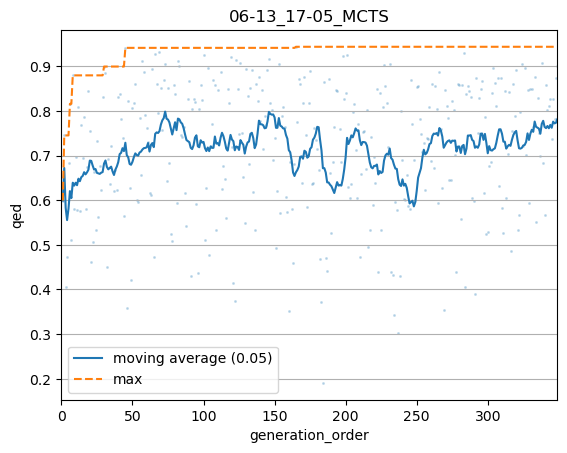

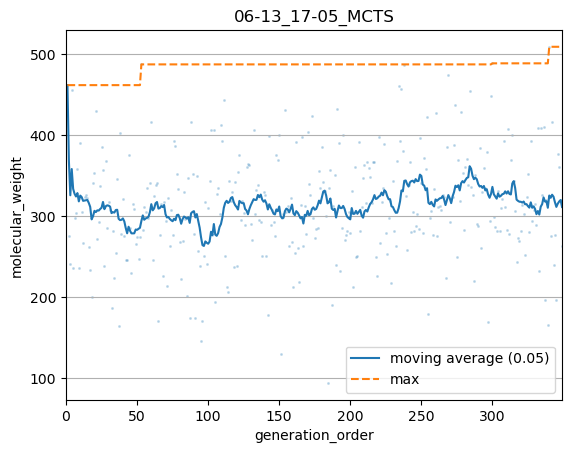

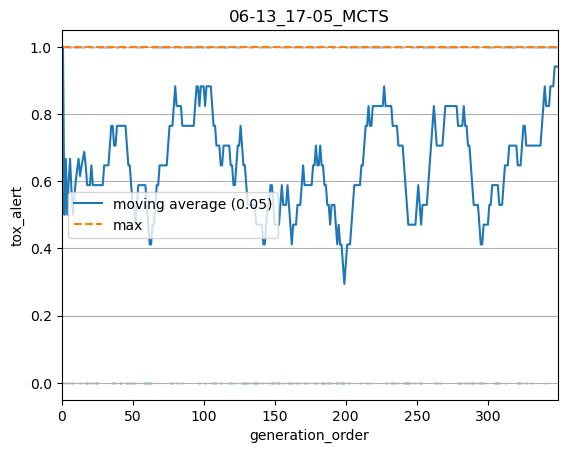

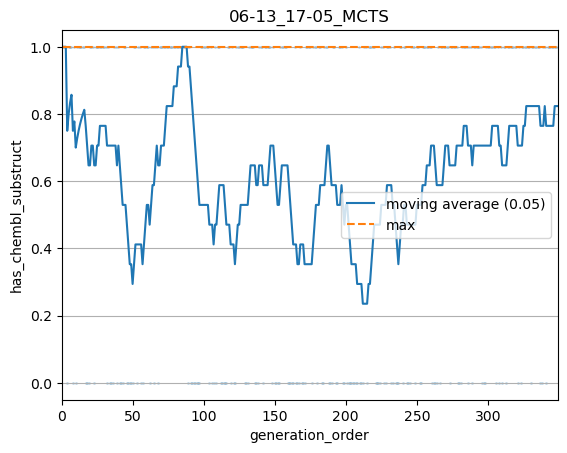

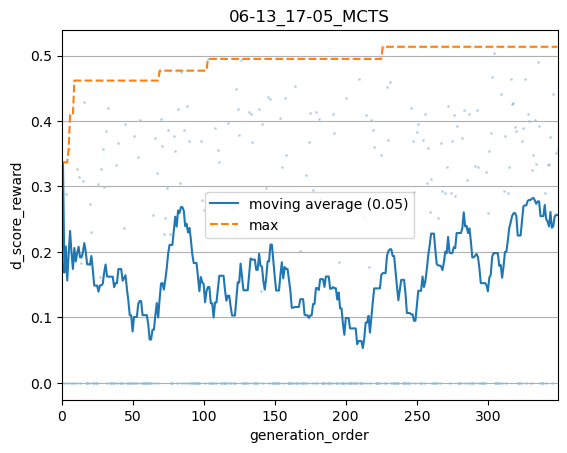

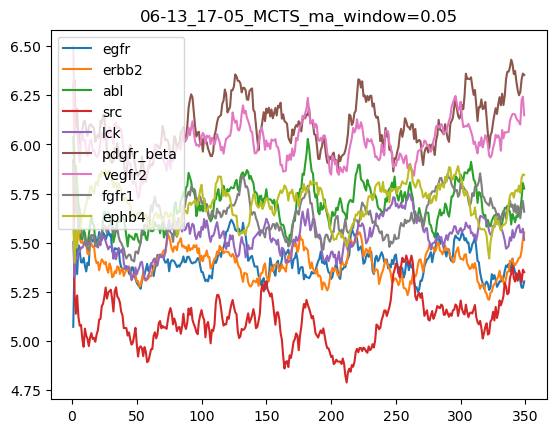

number of generated nodes: 349
valid rate: 0.4389937106918239
node_per_sec: 5.796860274074937


In [3]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization

generator = MCTS(root=root, transition=transition, reward=reward, policy=policy, filters=filters, filtered_reward=conf.get("filtered_reward"), output_dir=output_dir, logger=logger, **conf.get("generator_conf", {}))
src = os.path.join(repo_root, config_path)
dst = os.path.join(output_dir, "setting.yaml")
shutil.copy(src, dst)

generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
# cProfile.run("generator.generate(root=root, **generation_conf)"")
generator.plot(**conf.get("plot_conf", {}))
generator.analyze()

In [ ]:
#continue search
generator.generate(max_generations=10)
generator.plot(**conf.get("plot_conf", {}))
generator.analyze()

In [ ]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts
load_path = os.path.join(output_dir, "06-09_22-15_MCTS_PUCT/test.mcts")
generator = MCTS.load(load_path, transition)